# Autoencoder (AE), Variational Autoencoder (VAE) and Generative Adversarial Network (GAN)

Antonio Fonseca

GeoComput & ML

May 25th, 2021

Packages to be installed:

```
conda install -c conda-forge umap-learn
pip install phate
conda install -c conda-forge imageio
```

In [1]:
import numpy as np
import codecs
import copy
import json
import scipy.io
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from sklearn import manifold
import phate
import umap
import pandas as pd 
import scprep
from torch.nn import functional as F


import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,RandomSampler
from torchvision import datasets, transforms
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Loading the dataset and create dataloaders
mnist_train = datasets.MNIST(root = 'data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = datasets.MNIST(root = 'data', train=False, download=True, transform = transforms.ToTensor())


# Implementing an Autoencoder

Now that you have a basic neural network set up, we'll go through the steps of training an autoencoder that
can compress the input down to 2 dimensions, and then (attempt to) reconstruct the original image. This
will be similar to your previous network with one hidden layer, but with many more.
 - Fill in the Autoencoder class with a stack of layers of the following shape: 784-1000-500-250-2-250-
500-1000-784 You can make use of the nn.Linear function to automatically manage the creation of
weight and bias parameters. Between each layer, use a tanh activation.
 - Change the activation function going to the middle (2-dim) layer to linear (keeping the rest as tanh).
 - Use the sigmoid activation function on the output of the last hidden layer.
 - Adapt your training function for the autoencoder. Use the same batch size and number of steps (128
and 5000), but use the ADAM optimizer instead of Gradient Descent. Use Mean Squared Error for
your reconstruction loss.
 - After training your model, plot the 2 dimensional embeddings of 1000 digits, colored by the image
labels.
 - Produce side-by-side plots of one original and reconstructed sample of each digit (0 - 9). You can use
the save_image function from torchvision.utils.
 - Now for something fun: locate the embeddings of two distinct images, and interpolate between them
to produce some intermediate point in the latent space. Visualize this point in the 2D embedding.
Then, run your decoder on this fabricated "embedding" to see if it the output looks anything like a
handwritten digit. You might try interpolating between and within several different classes.

<img src="./images/AE_architecture.png" alt="drawing" width="800"/>

## Section 1

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(784, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)
        
        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 784)
        
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.tanh(x)
        x = self.enc_lin2(x)
        x = self.tanh(x)
        x = self.enc_lin3(x)
        x = self.tanh(x)
        x = self.enc_lin4(x)
        z = self.tanh(x)
        # ... additional layers, plus possible nonlinearities.
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [3]:
batch_size = 128
test_loader = torch.utils.data.DataLoader(mnist_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)
train_loader = torch.utils.data.DataLoader(mnist_train, 
                                          batch_size=batch_size, 
                                          shuffle=True)

In [5]:
## Second routine for training and evaluation (using the )
# Training and Evaluation routines
import time
def train(model,loss_fn, optimizer, train_loader, test_loader, num_epochs=None, verbose=False):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    print('optimizer: {}'.format(optimizer))
    if num_epochs is None:
        num_epochs = 100 # obviously, this is too many. I don't know what this author was thinking.
    print('n. of epochs: {}'.format(num_epochs))
    for epoch in range(num_epochs+1):
        start = time.time()
        # loop through each data point in the training set
        for data, targets in train_loader:
            
            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose: print('model_input.shape: {}'.format(model_input.shape))
                
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            out, _ = model(model_input) # The second output is the latent representation
            if verbose:
                print('targets.shape: {}'.format(targets.shape))
                print('out.shape: {}'.format(out.shape))

            # Calculate the loss
            targets = targets # add an extra dimension to keep CrossEntropy happy.
            if verbose: print('targets.shape: {}'.format(targets.shape))
            loss = loss_fn(out,model_input)
            if verbose: print('loss: {}'.format(loss))
            
            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        if epoch % 10==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            print(" Train loss: {:.4f}. Test loss: {:.4f}. Time: {:.4f}".format(evaluate(model,train_loader,verbose), evaluate(model,test_loader,verbose), (time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        loss_all=0
        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose:
                print('model_input.shape: {}'.format(model_input.shape))
                print('targets.shape: {}'.format(targets.shape))
            out,_ = model(model_input)
            loss = loss_fn(out,model_input)
        
            if verbose: print('out[:5]: {}'.format(out[:5]))
            loss_all+=loss.item()
        loss = loss_all/len(evaluation_set)
    return loss


# Autoencoding MNIST
<img src="./images/AE_MNIST.png" alt="drawing" width="800"/>

In [6]:
# hid_dim_range = [128,256,512]
lr_range = [0.01,0.005,0.001]
print('Autoencoder - with non-linearity (tanh)')
for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,verbose=False)

Autoencoder - with non-linearity (tanh)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 1.0428. Test loss: 1.0423. Time: 10.0248
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.8899. Test loss: 0.8877. Time: 9.6755
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.8899. Test loss: 0.8877. Time: 9.5361
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.8899. Test loss: 0.8877. Time: 9.4851
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.8899. Test loss: 0.8877. Time: 9.6068
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.8899. Test loss: 0.8877. Time: 9.5639
 EPOCH 60. Progress: 60.0%. 
 Train loss: 0.8899. Test loss: 0.8877. Time: 9.5320
 EPOCH 70. Progress: 70.0%. 
 Train loss: 0.8899. Test loss: 0.8877. Time: 9.5468
 EPOCH 80. Progress: 80.0%. 
 Train loss: 0.8899. Test loss: 0.8877. Time: 9.5872
 EPOCH 90. Progress: 90.0%. 
 Train loss: 0.8899. Test loss: 0.8877. Time: 9

In [6]:
# Training for longer with the lr that gave best result
lr_range = [0.001]
print('Autoencoder - with non-linearity (tanh)')
for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) 
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,num_epochs=500,verbose=False)
    
# # Save the trained model 
# torch.save(model.state_dict(), './models/model_AE.pt')

Autoencoder - with non-linearity (tanh)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0498. Test loss: 0.0500. Time: 9.8799
 EPOCH 10. Progress: 2.0%. 
 Train loss: 0.0413. Test loss: 0.0415. Time: 9.5658
 EPOCH 20. Progress: 4.0%. 
 Train loss: 0.0390. Test loss: 0.0392. Time: 9.5774
 EPOCH 30. Progress: 6.0%. 
 Train loss: 0.0380. Test loss: 0.0381. Time: 9.5850
 EPOCH 40. Progress: 8.0%. 
 Train loss: 0.0371. Test loss: 0.0373. Time: 9.5798
 EPOCH 50. Progress: 10.0%. 
 Train loss: 0.0368. Test loss: 0.0369. Time: 9.5161
 EPOCH 60. Progress: 12.0%. 
 Train loss: 0.0363. Test loss: 0.0365. Time: 9.6184
 EPOCH 70. Progress: 14.000000000000002%. 
 Train loss: 0.0359. Test loss: 0.0361. Time: 9.4047
 EPOCH 80. Progress: 16.0%. 
 Train loss: 0.0357. Test loss: 0.0359. Time: 9.5648
 EPOCH 90. Progress: 18.0%. 
 Train loss: 0.0356. Test loss: 0.035

In [7]:
# Load the model
model_AE = Autoencoder().to(device)
model_AE.load_state_dict(torch.load('./models/model_AE.pt'))

<All keys matched successfully>

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])


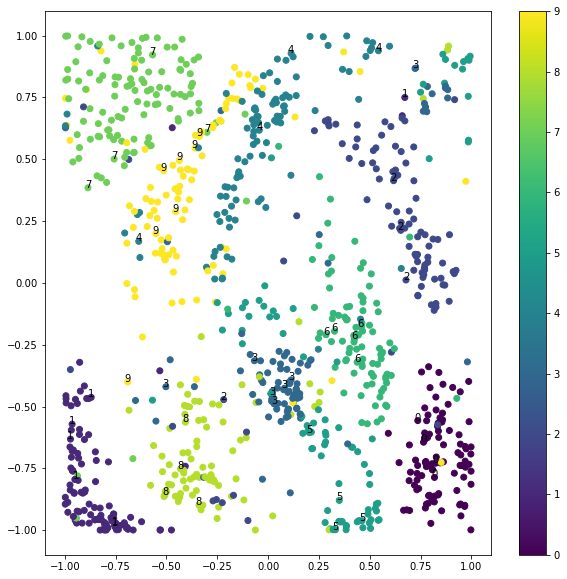

In [8]:
## Plot the embedding of 1000 digits
# Test
large_batch = torch.utils.data.DataLoader(mnist_train, 
                                          batch_size=1000, 
                                          shuffle=False)

with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    
    plt.colorbar(ticks=range(10))

    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center


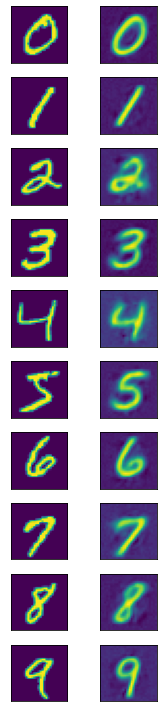

In [9]:
with torch.no_grad():
    data, targets = next(iter(large_batch))
    model_input = data.view(data.size(0),-1).to(device)
    out, latentVar = model_AE(model_input)
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    model_input = model_input.cpu().numpy()
    out = out.cpu().numpy()

    fig,ax = plt.subplots(10,2,figsize=(3,10))
    ax = ax.ravel()
    count=0
    for idx1 in range(10):
        for idx2 in range(len(targets)): #Looking for the digit among the labels
            if idx1==targets[idx2]:
                ax[count].imshow(model_input[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                ax[count].imshow(out[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                break

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
targets[:20]: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
latentVar[:20]: [[ 0.20221455 -0.60549915]
 [ 0.8239314  -0.72916347]
 [ 0.11328162  0.92810714]
 [-0.7525426  -0.9826892 ]
 [-0.5522595   0.19914474]
 [ 0.67841876  0.01163787]
 [-0.8704568  -0.46279657]
 [ 0.02959244 -0.4888631 ]
 [-0.9643847  -0.5712018 ]
 [-0.04333534  0.6172683 ]
 [ 0.11311392 -0.39219323]
 [ 0.3312359  -0.9982074 ]
 [-0.06723219 -0.31480914]
 [ 0.45514885 -0.17654124]
 [-0.97248226 -0.63170075]
 [-0.5684172   0.9217198 ]
 [ 0.6529771   0.21242161]
 [-0.50694114 -0.8574053 ]
 [ 0.28491265 -0.20937432]
 [-0.4365405   0.4949173 ]]
x0,y0: 0.2022145539522171,-0.6054991483688354
x1,y1: 0.8239313960075378,-0.7291634678840637
xvals: [0.20221455 0.2712942  0.34037385 0.4094535  0.47853315 0.5476128
 0.61669245 0.6857721  0.75485175 0.8239314 ]
yvals: [-0.60549915 -0.61923963 -0.63298011 -0.64672059 -0.66

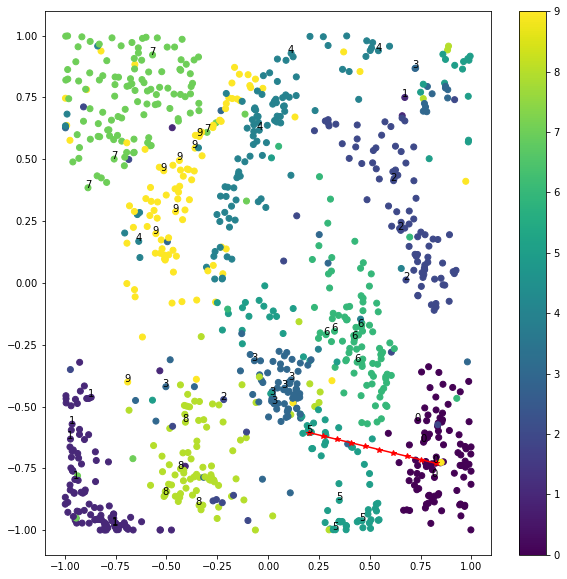

In [10]:
# Interpolate between two images of different classes
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[0,0],latentVar[0,1]
    x1,y1 = latentVar[1,0],latentVar[1,1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')
    

In [11]:
class AE_decoder(nn.Module):
    def __init__(self):
        super(AE_decoder, self).__init__()
        self.dec_lin1 = model_AE.dec_lin1
        self.dec_lin2 = model_AE.dec_lin2
        self.dec_lin3 = model_AE.dec_lin3 
        self.dec_lin4 = model_AE.dec_lin4
        
        self.tanh = nn.Tanh()

    def forward(self,z):
        # ditto, but in reverse
        print('z: {}'.format(z))
        print('z.shape: {}'.format(z.shape))
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

model_input: tensor([ 0.2022, -0.6055])
z: tensor([ 0.2022, -0.6055], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.2713, -0.6192])
z: tensor([ 0.2713, -0.6192], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.3404, -0.6330])
z: tensor([ 0.3404, -0.6330], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.4095, -0.6467])
z: tensor([ 0.4095, -0.6467], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.4785, -0.6605])
z: tensor([ 0.4785, -0.6605], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.5476, -0.6742])
z: tensor([ 0.5476, -0.6742], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.6167, -0.6879])
z: tensor([ 0.6167, -0.6879], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.6858, -0.7017])
z: tensor([ 0.6858, -0.7017], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.7549, -0.7154])
z: tensor([ 0.7549, -0.7154], device='cuda:0')
z.shape: torch.Si

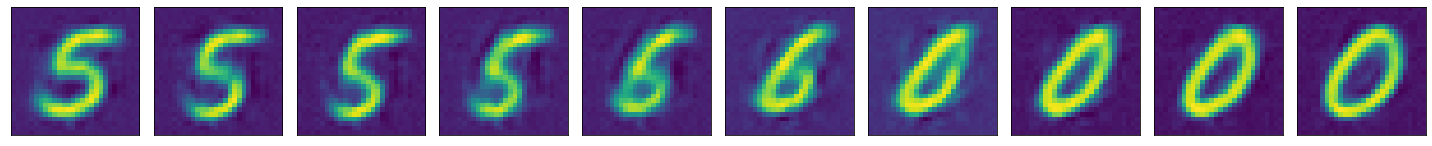

In [12]:
# Decode the interpolated points across classes
with torch.no_grad():

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        model = AE_decoder()

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
[13 18]
targets[:20]: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
latentVar[:20]: [[ 0.20221455 -0.60549915]
 [ 0.8239314  -0.72916347]
 [ 0.11328162  0.92810714]
 [-0.7525426  -0.9826892 ]
 [-0.5522595   0.19914474]
 [ 0.67841876  0.01163787]
 [-0.8704568  -0.46279657]
 [ 0.02959244 -0.4888631 ]
 [-0.9643847  -0.5712018 ]
 [-0.04333534  0.6172683 ]
 [ 0.11311392 -0.39219323]
 [ 0.3312359  -0.9982074 ]
 [-0.06723219 -0.31480914]
 [ 0.45514885 -0.17654124]
 [-0.97248226 -0.63170075]
 [-0.5684172   0.9217198 ]
 [ 0.6529771   0.21242161]
 [-0.50694114 -0.8574053 ]
 [ 0.28491265 -0.20937432]
 [-0.4365405   0.4949173 ]]
x0,y0: 0.455148845911026,-0.17654123902320862
x1,y1: 0.284912645816803,-0.2093743234872818
xvals: [0.45514885 0.43623371 0.41731858 0.39840345 0.37948831 0.36057318
 0.34165805 0.32274291 0.30382778 0.28491265]
yvals: [-0.17654124 -0.18018936 -0.18383748 -0.187485

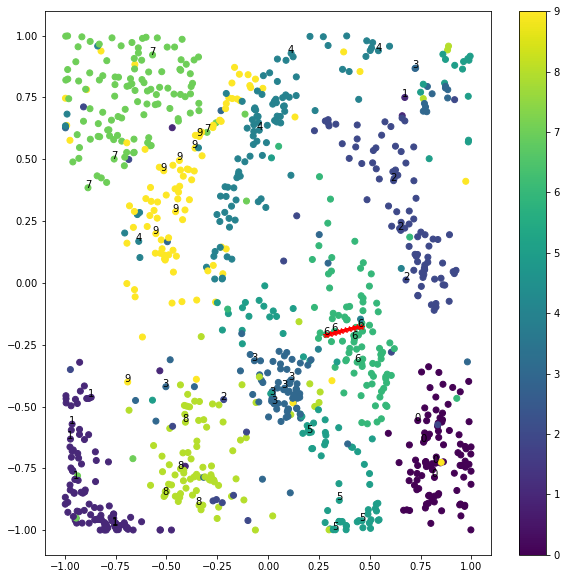

In [13]:
# Interpolate between two images of the same class
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    idx_ = np.where(targets==6)[0] # Get two '6'.
    print(idx_[:2])

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[idx_[0],0],latentVar[idx_[0],1]
    x1,y1 = latentVar[idx_[1],0],latentVar[idx_[1],1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')
    

model_input: tensor([ 0.4551, -0.1765])
z: tensor([ 0.4551, -0.1765], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.4362, -0.1802])
z: tensor([ 0.4362, -0.1802], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.4173, -0.1838])
z: tensor([ 0.4173, -0.1838], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.3984, -0.1875])
z: tensor([ 0.3984, -0.1875], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.3795, -0.1911])
z: tensor([ 0.3795, -0.1911], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.3606, -0.1948])
z: tensor([ 0.3606, -0.1948], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.3417, -0.1984])
z: tensor([ 0.3417, -0.1984], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.3227, -0.2021])
z: tensor([ 0.3227, -0.2021], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.3038, -0.2057])
z: tensor([ 0.3038, -0.2057], device='cuda:0')
z.shape: torch.Si

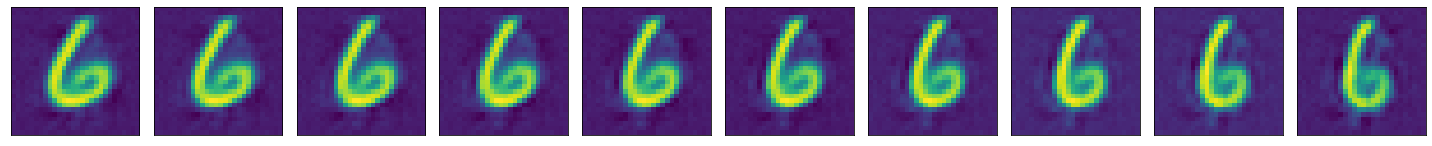

In [14]:
with torch.no_grad():

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        model = AE_decoder()

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

In [15]:
# Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(784, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)
        
        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 784)
        
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.tanh(x)
        x = self.enc_lin2(x)
        x = self.tanh(x)
        x = self.enc_lin3(x)
        x = self.tanh(x)
        x = self.enc_lin4(x)
        z = x
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [17]:
lr_range = [0.01,0.005,0.001]
print('Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else')
for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) 
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,verbose=False)

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.8617. Test loss: 0.8591. Time: 9.4712
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.8617. Test loss: 0.8591. Time: 9.4638
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.8617. Test loss: 0.8591. Time: 9.5027
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.8617. Test loss: 0.8591. Time: 9.4711
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.8617. Test loss: 0.8591. Time: 9.4828
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.8617. Test loss: 0.8591. Time: 9.4912
 EPOCH 60. Progress: 60.0%. 
 Train loss: 0.8617. Test loss: 0.8591. Time: 9.5242
 EPOCH 70. Progress: 70.0%. 
 Train loss: 0.8617. Test loss: 0.8591. Time: 9.4808
 EPOCH 80. Progress: 80.0%. 
 Train loss: 0.8617. Test loss: 0.8591. Time: 9.5575

In [18]:
# Training for longer with the lr that gave best result
lr_range = [0.001]
print('Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else')
# for hid_dim in hid_dim_range:
for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) 
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,num_epochs=500,verbose=False)
    
# # Save the trained model 
# torch.save(model.state_dict(), './models/model_AE_linear.pt')

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0462. Test loss: 0.0461. Time: 9.2585
 EPOCH 10. Progress: 2.0%. 
 Train loss: 0.0375. Test loss: 0.0376. Time: 9.4987
 EPOCH 20. Progress: 4.0%. 
 Train loss: 0.0358. Test loss: 0.0362. Time: 9.7496
 EPOCH 30. Progress: 6.0%. 
 Train loss: 0.0355. Test loss: 0.0358. Time: 9.4185
 EPOCH 40. Progress: 8.0%. 
 Train loss: 0.0346. Test loss: 0.0352. Time: 9.5354
 EPOCH 50. Progress: 10.0%. 
 Train loss: 0.0342. Test loss: 0.0346. Time: 9.4688
 EPOCH 60. Progress: 12.0%. 
 Train loss: 0.0341. Test loss: 0.0346. Time: 9.3935
 EPOCH 70. Progress: 14.000000000000002%. 
 Train loss: 0.0340. Test loss: 0.0346. Time: 9.5204
 EPOCH 80. Progress: 16.0%. 
 Train loss: 0.0337. Test loss: 0.0343. T

In [19]:
# Load the model
model_AE_linear = Autoencoder().to(device)
model_AE_linear.load_state_dict(torch.load('./models/model_AE_linear.pt'))

<All keys matched successfully>

In [20]:
class AE_decoder(nn.Module):
    "Bert Model : Masked LM and next sentence classification"
    def __init__(self):
        super(AE_decoder, self).__init__()
        self.dec_lin1 = model_AE_linear.dec_lin1
        self.dec_lin2 = model_AE_linear.dec_lin2
        self.dec_lin3 = model_AE_linear.dec_lin3 
        self.dec_lin4 = model_AE_linear.dec_lin4
        
        self.tanh = nn.Tanh()

    def forward(self,z):
        # ditto, but in reverse
        print('z: {}'.format(z))
        print('z.shape: {}'.format(z.shape))
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

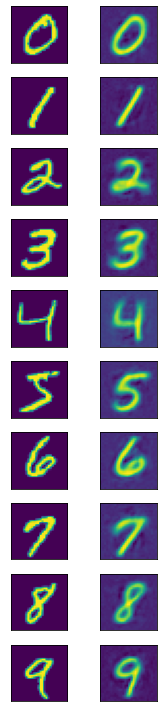

In [21]:
large_batch = torch.utils.data.DataLoader(mnist_train, 
                                          batch_size=1000, 
                                          shuffle=False)

with torch.no_grad():
    data, targets = next(iter(large_batch))
    model_input = data.view(data.size(0),-1).to(device)
    out, latentVar = model_AE_linear(model_input)
#     print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    model_input = model_input.cpu().numpy()
    out = out.cpu().numpy()

    fig,ax = plt.subplots(10,2,figsize=(3,10))
    ax = ax.ravel()
    count=0
    for idx1 in range(10):
        for idx2 in range(len(targets)): #Looking for the digit among the labels
            if idx1==targets[idx2]:
                ax[count].imshow(model_input[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                ax[count].imshow(out[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                break

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
[13 18]
targets[:20]: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
latentVar[:20]: [[  0.8865606    1.5480741 ]
 [ 16.731844    -7.276614  ]
 [ -2.4016175   -6.888707  ]
 [-18.124239    19.383165  ]
 [ -7.165092    -8.911613  ]
 [  0.5757658   23.241972  ]
 [-15.745468     6.39673   ]
 [  2.395832     1.0412631 ]
 [-21.963514    12.41907   ]
 [ -9.068372    -1.1200744 ]
 [  3.6217608    2.2020106 ]
 [ -0.5407217    0.3420028 ]
 [  4.266301     5.598924  ]
 [ 10.783975    -9.347283  ]
 [-21.905464    10.90397   ]
 [-13.451579   -10.4015    ]
 [ -1.0420249   20.486029  ]
 [ -2.6018767    2.6364672 ]
 [ 12.088467     0.17695254]
 [ -6.264395    -0.39840573]]
x0,y0: 10.783974647521973,-9.347283363342285
x1,y1: 12.08846664428711,0.1769525408744812
xvals: [10.78397465 10.9289182  11.07386176 11.21880531 11.36374887 11.50869242
 11.65363598 11.79857953 11.94352309 12.08846664]
yvals

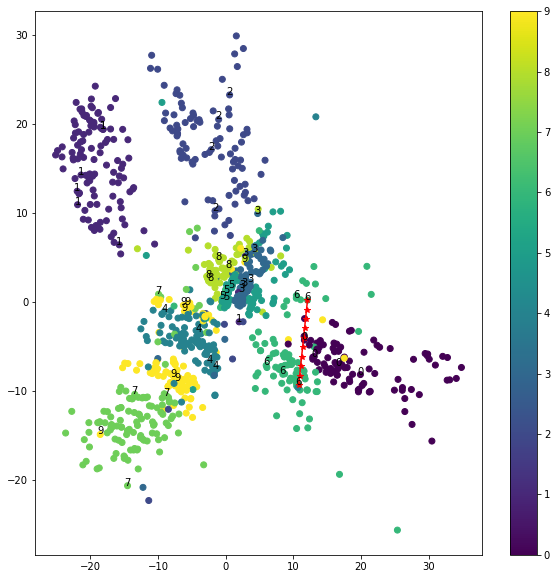

In [22]:
# Interpolate between two images of the same class
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE_linear(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    idx_ = np.where(targets==6)[0] # Get two '6'.
    print(idx_[:2])

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[idx_[0],0],latentVar[idx_[0],1]
    x1,y1 = latentVar[idx_[1],0],latentVar[idx_[1],1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')
    

model_input: tensor([10.7840, -9.3473])
z: tensor([10.7840, -9.3473], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([10.9289, -8.2890])
z: tensor([10.9289, -8.2890], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([11.0739, -7.2308])
z: tensor([11.0739, -7.2308], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([11.2188, -6.1725])
z: tensor([11.2188, -6.1725], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([11.3637, -5.1143])
z: tensor([11.3637, -5.1143], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([11.5087, -4.0560])
z: tensor([11.5087, -4.0560], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([11.6536, -2.9978])
z: tensor([11.6536, -2.9978], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([11.7986, -1.9395])
z: tensor([11.7986, -1.9395], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([11.9435, -0.8813])
z: tensor([11.9435, -0.8813], device='cuda:0')
z.shape: torch.Si

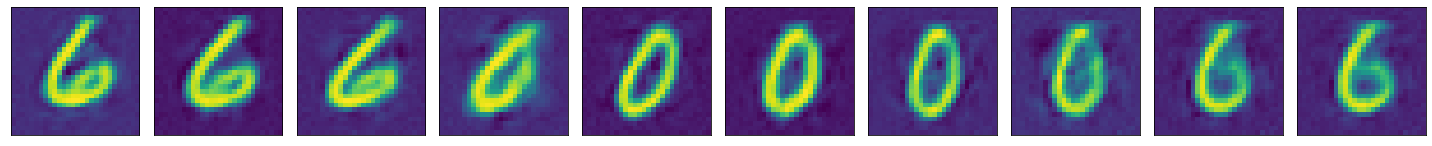

In [23]:
with torch.no_grad():

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        model = AE_decoder()

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
targets[:20]: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
latentVar[:20]: [[  0.8865606    1.5480741 ]
 [ 16.731844    -7.276614  ]
 [ -2.4016175   -6.888707  ]
 [-18.124239    19.383165  ]
 [ -7.165092    -8.911613  ]
 [  0.5757658   23.241972  ]
 [-15.745468     6.39673   ]
 [  2.395832     1.0412631 ]
 [-21.963514    12.41907   ]
 [ -9.068372    -1.1200744 ]
 [  3.6217608    2.2020106 ]
 [ -0.5407217    0.3420028 ]
 [  4.266301     5.598924  ]
 [ 10.783975    -9.347283  ]
 [-21.905464    10.90397   ]
 [-13.451579   -10.4015    ]
 [ -1.0420249   20.486029  ]
 [ -2.6018767    2.6364672 ]
 [ 12.088467     0.17695254]
 [ -6.264395    -0.39840573]]
x0,y0: 0.8865606188774109,1.5480741262435913
x1,y1: 16.731843948364258,-7.276614189147949
xvals: [ 0.88656062  2.64714766  4.40773469  6.16832173  7.92890877  9.6894958
 11.45008284 13.21066988 14.97125691 16.73184395]
yvals: [ 1.54

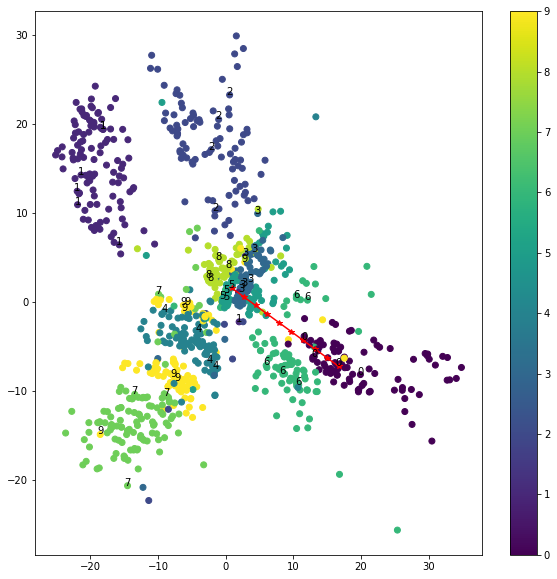

In [24]:
# Interpolate between two images of different classes
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE_linear(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[0,0],latentVar[0,1]
    x1,y1 = latentVar[1,0],latentVar[1,1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')
    

model_input: tensor([0.8866, 1.5481])
z: tensor([0.8866, 1.5481], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([2.6471, 0.5676])
z: tensor([2.6471, 0.5676], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 4.4077, -0.4130])
z: tensor([ 4.4077, -0.4130], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 6.1683, -1.3935])
z: tensor([ 6.1683, -1.3935], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 7.9289, -2.3740])
z: tensor([ 7.9289, -2.3740], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 9.6895, -3.3545])
z: tensor([ 9.6895, -3.3545], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([11.4501, -4.3351])
z: tensor([11.4501, -4.3351], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([13.2107, -5.3156])
z: tensor([13.2107, -5.3156], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([14.9713, -6.2961])
z: tensor([14.9713, -6.2961], device='cuda:0')
z.shape: torch.Size([2])


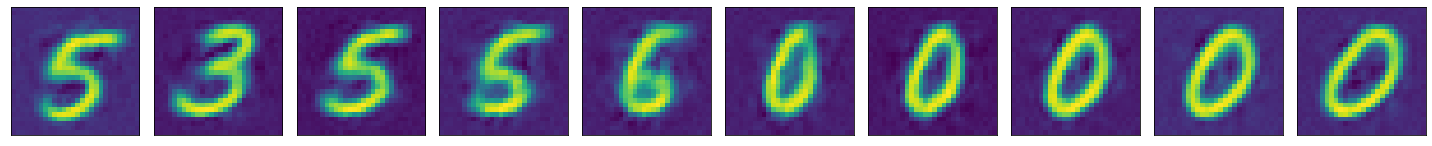

In [25]:
with torch.no_grad():

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        model = AE_decoder()

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

## Question 1.1. 
__Do the colors easily separate, or are they all clumped together? Which numbers are frequently embedded close together, and what does this mean?__

## Question 1.2. 
__How realistic were the images you generated by interpolating between points in the latent space? Can you think of a better way to generate images with an autoencoder?__

# Section 2

Now that we have an autoencoder working on MNIST, let's use this model to visualize some geodata. For the next section we will use the SAT-6 (https://csc.lsu.edu/~saikat/deepsat/)

SAT-6 consists of a total of 405,000 image patches each of size 28x28 and covering <span style="color:red"> 6 landcover classes - barren land, trees, grassland, roads, buildings and water bodies</span>. 324,000 images (comprising of four-fifths of the total dataset) were chosen as the training dataset and 81,000 (one fifths) were chosen as the testing dataset. Similar to SAT-4, the training and test sets were selected from disjoint NAIP tiles. Once generated, the images in the dataset were randomized in the same way as that for SAT-4. The specifications for the various landcover classes of SAT-4 and SAT-6 were adopted from those used in the National Land Cover Data (NLCD) algorithm. 

The datasets are encoded as MATLAB .mat files that can be read using the standard load command in MATLAB.  <span style="color:red">Each sample image is 28x28 pixels and consists of 4 bands - red, green, blue and near infrared </span>. The training and test labels are 1x4 and 1x6 vectors for SAT-4 and SAT-6 respectively having a single 1 indexing a particular class from 0 through 4 or 6 and 0 values at all other indices.

The MAT file for the SAT-6 dataset contains the following variables:

- train_x	28x28x4x324000 uint8 (containing 324000 training samples of 28x28 images each with 4 channels)
- train_y	324000x6 uint8 (containing 6x1 vectors having labels for the 324000 training samples)
- test_x	28x28x4x81000 uint8 (containing 81000 test samples of 28x28 images each with 4 channels)
- test_y	81000x6 uint8 (containing 6x1 vectors having labels for the 81000 test samples)

In [26]:
# Using the satelite images dataset
###############################################################################
#load the data
data = scipy.io.loadmat("./data/sat-6-full.mat")
train_images = data['train_x']
train_labels = data['train_y']

test_images = data['test_x']
test_labels = data['test_y']

In [27]:
####################################################################
#Checkout the data
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

Training data shape :  (28, 28, 4, 324000) (6, 324000)
Testing data shape :  (28, 28, 4, 81000) (6, 81000)


In [28]:
#Change the dimension to fit into the model
x_train = train_images.transpose(3,0,1,2)
t_train = train_labels.transpose()

x_test = test_images.transpose(3,0,1,2)
t_test = test_labels.transpose()
print('Training data shape : ', x_train.shape, t_train.shape)
print('Testing data shape : ', x_test.shape, t_test.shape)

Training data shape :  (324000, 28, 28, 4) (324000, 6)
Testing data shape :  (81000, 28, 28, 4) (81000, 6)


count, t_train[count,:]: 0, [0 0 1 0 0 0]
count, t_train[count,:]: 1, [0 1 0 0 0 0]
count, t_train[count,:]: 2, [0 0 0 0 0 1]
count, t_train[count,:]: 3, [0 0 0 0 0 1]
count, t_train[count,:]: 4, [0 0 0 0 0 1]
count, t_train[count,:]: 5, [1 0 0 0 0 0]
count, t_train[count,:]: 6, [1 0 0 0 0 0]
count, t_train[count,:]: 7, [0 0 0 0 0 1]
count, t_train[count,:]: 8, [0 1 0 0 0 0]
count, t_train[count,:]: 9, [0 0 1 0 0 0]
count, t_train[count,:]: 10, [0 0 0 0 0 1]
count, t_train[count,:]: 11, [0 1 0 0 0 0]
count, t_train[count,:]: 12, [0 1 0 0 0 0]
count, t_train[count,:]: 13, [0 0 0 0 1 0]
count, t_train[count,:]: 14, [0 0 0 0 0 1]
count, t_train[count,:]: 15, [0 0 1 0 0 0]


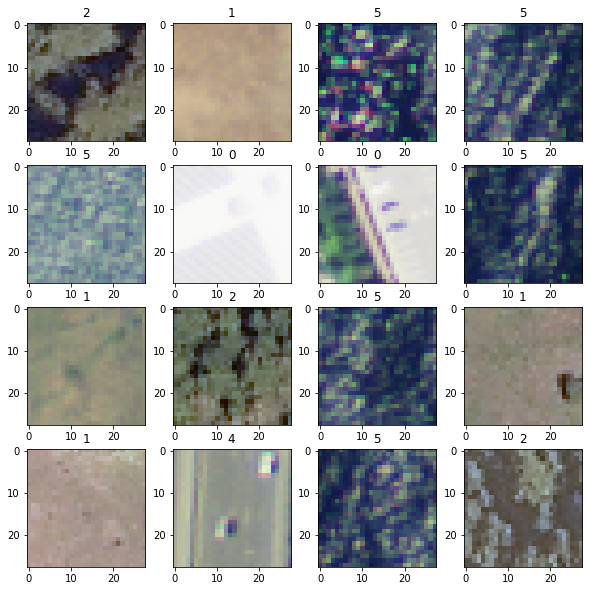

In [29]:
#Check what is in each channel
fig,ax = plt.subplots(4,4, figsize=(10,10))
ax = ax.ravel()
list_idx = np.linspace(0,100,num=16,dtype=np.int64)
for count, idx in enumerate(list_idx):
#     print(idx)
    print('count, t_train[count,:]: {}, {}'.format(count, t_train[count,:]))
#     print(x_train[idx,:,:,0:3])
    ax[count].imshow(x_train[count,:,:,0:3])
    ax[count].set_title(str(np.argmax(t_train[count,:])))

In [30]:
# split in training and testing
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from scipy.ndimage import zoom


class MyDataset(Dataset):
    def __init__(self, data, target):
        print('data.dtype: {}'.format(data.dtype))
        print('target.dtype: {}'.format(target.dtype))
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

print('x_train.shape: {}'.format(x_train.shape))
dataset = MyDataset(x_train, np.argmax(t_train,axis=1))
dataset_size  = len(dataset)
print('dataset_size: {}'.format(dataset_size))
test_split=0.2

# Number of frames in the sequence (in this case, same as number of tokens). Maybe I can make this number much bigger, like 4 times bigger, and then do the batches of batches...
# For example, when classifying, I can test if the first and the second chunk are sequence vs the first and third
batch_size=1024 #Originally 16 frames... can I do 128 and then split in 4 chunks of 32

# -- split dataset
indices       = list(range(dataset_size))
split         = int(np.floor(test_split*dataset_size))
print('split: {}'.format(split))
# np.random.shuffle(indices) # Randomizing the indices is not a good idea if you want to model the sequence
train_indices, val_indices = indices[split:], indices[:split]

# -- create dataloaders
# #Original
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloaders   = {
    'train': torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=6, sampler=train_sampler),
    'test': torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=6, sampler=valid_sampler),
    'all': torch.utils.data.DataLoader(dataset,  batch_size=dataset_size, num_workers=6, shuffle=False),
    }

x_train.shape: (324000, 28, 28, 4)
data.dtype: uint8
target.dtype: int64
dataset_size: 324000
split: 64800


In [31]:
class Autoencoder(nn.Module):
    '''
    Linear activation in the middle (instead of an activation function)
    '''
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(3136, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)
        
        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 3136)
        
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.tanh(x)
        x = self.enc_lin2(x)
        x = self.tanh(x)
        x = self.enc_lin3(x)
        x = self.tanh(x)
        x = self.enc_lin4(x)
        z = x
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [33]:
lr_range = [0.01,0.005,0.001]
print('Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, dataloaders['train'], dataloaders['test'],verbose=False)

In [34]:
class Autoencoder(nn.Module):
    '''
    Linear activation in the middle (instead of an activation function and relus)
    '''
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(3136, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)
        
        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 3136)
        
#         self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.relu(x)
        x = self.enc_lin2(x)
        x = self.relu(x)
        x = self.enc_lin3(x)
        x = self.relu(x)
        x = self.enc_lin4(x)
        z = x
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.relu(x)
        x = self.dec_lin2(x)
        x = self.relu(x)
        x = self.dec_lin3(x)
        x = self.relu(x)
        x = self.dec_lin4(x)
        x = self.relu(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [ ]:
lr_range = [0.01,0.005,0.001, 0.0005]
print('Autoencoder - with linear activation in middle layer and non-linearity (relu) everywhere else')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, dataloaders['train'], dataloaders['test'],verbose=False)

In [ ]:
# Train the best config for longer
lr_range = [0.001]
print('Autoencoder - with linear activation in middle layer and non-linearity (relu) everywhere else')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, dataloaders['train'], dataloaders['test'],num_epochs=1000, verbose=False)

In [ ]:
# #Save this model
# torch.save(model.state_dict(), './models/model_AE_sat6_v2.pt')

In [35]:
if 'model' in globals():
    print('Deleting "model"')
    del model

Deleting "model"


In [37]:
# Load the model
model = Autoencoder().to(device)
model.load_state_dict(torch.load('./models/model_AE_sat6.pt'))

<All keys matched successfully>

In [38]:
if 'model_input' in globals():
    print('Deleting "model_input"')
    del model_input

if 'out' in globals():
    print('Deleting "out"')
    del out

if 'latentVar' in globals():
    print('Deleting "latentVar"')
    del latentVar
    
plt.close('all')

Deleting "model_input"
Deleting "out"
Deleting "latentVar"


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0b2814d8c0>
Traceback (most recent call last):
  File "/home/antonio2/miniconda3/envs/2pmeso_BERT/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/antonio2/miniconda3/envs/2pmeso_BERT/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/antonio2/miniconda3/envs/2pmeso_BERT/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


targets.shape: torch.Size([324000])
np.unique(targets): [0. 1. 2. 3. 4. 5.]
latentVar.shape: torch.Size([324000, 2])
targets[:20]: [2. 1. 5. 5. 5. 0. 0. 5. 1. 2. 5. 1. 1. 4. 5. 2. 5. 3. 3. 1.]
latentVar[:20]: [[-22.65419     5.3563366]
 [-38.309372   13.54262  ]
 [ -4.897646   10.544073 ]
 [ -8.371048    8.8982315]
 [-13.901421   17.608849 ]
 [-46.517227   23.859848 ]
 [ -2.5415516  34.010395 ]
 [ -4.0781636   8.349135 ]
 [-34.823757   10.2291565]
 [-80.440575  -24.84828  ]
 [ -7.943358    8.423912 ]
 [-35.214306    9.433654 ]
 [-38.87881    12.459201 ]
 [-22.894802   16.725945 ]
 [ -5.7261662  10.493533 ]
 [-54.75086    -9.278495 ]
 [ -8.728942   10.757288 ]
 [-67.66758   -12.463574 ]
 [-88.861626  -26.455873 ]
 [-35.756603   13.151304 ]]


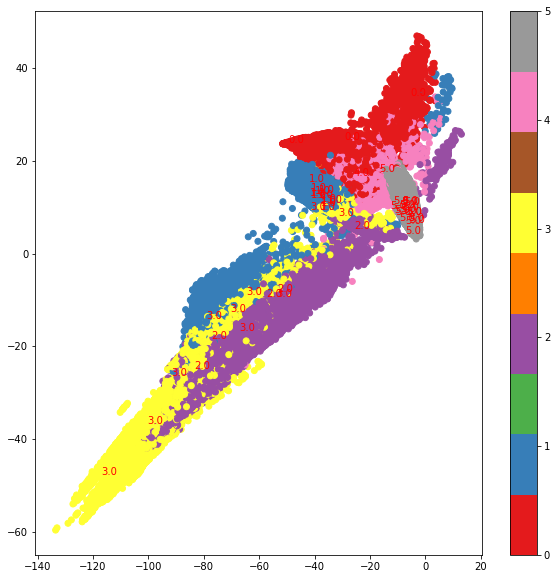

In [39]:
# Interpolate between two images of different classes
with torch.no_grad():
    data, targets = next(iter(dataloaders['all']))
    
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model(model_input)
    del out, model_input
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:],cmap='Set1')
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(26))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

## Question 2.1. 
__How many clusters are visible in the embedding? Do they correspond to the cluster labels?__

# Section 3 - Generative Models

Now, let's try something more interesting: generating data. In this section, you'll implement a variation of the autoencoder (called a "Variational Autoencoder") and a Generative Adversiarial Network, and will employ both to create never-before seen handwritten digits.

## Section 3.1 - Variational Autoencoder

Autoencoders are great, but their latent spaces can be messy. You may have noticed previously that the AE's embedding of MNIST clumped each digit into separate islands, with some overlap but also large empty regions. As you saw, the points in these empty parts of the embedding don't correspond well to real digits. 

Embedding generated by AE:

<img src="./images/AE_embed_example.png" alt="drawing" width="800"/>

This is the founding idea of the Variational Autoencoder, which makes two modifications to make interpolation within the latent space more meaningful. The first modification is the strangest: instead of encoding points in a latent space, the encoder creates a gaussian probability distribution around the encoded point, with a mean and squared variance unique to each point. The decoder is then passed a random sample from this distribution. This encourages similar points in the latent space to correspond to similar outputs, since the decoder only gets to choose a point close to the encoded original.

<img src="./images/VAE_architecture.png" alt="drawing" width="800"/>

If the first of these regularizations encourages similar latent representations within clusters, the second enforces proximity between clusters. This is achieved with the Kullback Leibler (KL) divergence, which tabulates the dissimilarity of the previously generated gaussian with a standard normal distribution; measuring, in effect, how much the varaince and mean differ from a variance of one and mean of zero. This prevents any class of embeddings from drifting too far away from the others. The KL divergence between two normal distributions is given by:

$D_{KL}[N(\mu,\sigma)||N(0,1)] = (1/2)\sum{1 + log\sigma^2-\mu^2-\sigma^2}$

where the sum is taken over each dimension in the latent space. 

<img src="./images/VAE_KLDiv.png" alt="drawing" width="800"/>
<img src="./images/VAE_Loss.png" alt="drawing" width="800"/>
<img src="./images/VAE_embed_example.png" alt="drawing" width="800"/>

An excellent and highly entertaining introduction to Variational Autoencoders may be found in David Foster's book, "Generative Deep Learning". Additionally, the mathematically inclined may enjoy Kingma and Welling's 2013 paper "Auto-encoding Variational Bayes" (https://arxiv.org/pdf/1312.6114) which first presented the theoretical foundations for the Variational Autoencoder.

In [40]:
'''
Ref: https://github.com/pytorch/examples/blob/master/vae/main.py
'''

import argparse
import torch
import os
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

path_to_save = './plots_VAE'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
        
class Args:
    batch_size = 128
    epochs = 50
    seed = 1
    no_cuda=False
    log_interval=100

args=Args()

args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu") # Use NVIDIA CUDA GPU if available

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss_MSE = nn.MSELoss().to(device)

def VAE_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1,784), reduction='sum')

    # Compute the KLD
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss, KLD


def train(epoch):
    model.train()
    train_loss = 0
    train_KLD=0
    train_recon_loss=0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        recon_loss, KLD = VAE_loss_function(recon_batch, data, mu, logvar)
        loss = recon_loss + KLD
        loss.backward()
        train_loss += loss.item()
        train_KLD += KLD.item()
        train_recon_loss += recon_loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
#                 recon_loss.item() / len(data),
#                 KLD.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.6f} (Loss_recon: {:.6f}, Loss_KLD: {:.6f})'.format(
          epoch, train_loss / len(train_loader.dataset), train_recon_loss/ len(train_loader.dataset),
                train_KLD / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    test_KLD=0
    test_recon_loss=0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
#             test_loss += VAE_loss_function(recon_batch, data, mu, logvar).item()
            recon_loss, KLD = VAE_loss_function(recon_batch, data, mu, logvar)
            loss = recon_loss + KLD
            test_recon_loss += recon_loss.item()
            test_KLD += KLD.item()
            test_loss += loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), './plots_VAE/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.6f} (Loss_recon: {:.6f}, Loss_KLD: {:.6f})\n'.format(test_loss, test_recon_loss/ len(test_loader.dataset),
                test_KLD / len(test_loader.dataset)))


In [41]:
if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       './plots_VAE/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.595764
Train Epoch: 1 [12800/60000 (21%)]	Loss: 267.992493
Train Epoch: 1 [25600/60000 (43%)]	Loss: 233.523529
Train Epoch: 1 [38400/60000 (64%)]	Loss: 214.352066
Train Epoch: 1 [51200/60000 (85%)]	Loss: 204.011124
====> Epoch: 1 Average loss: 260.137702 (Loss_recon: 244.047558, Loss_KLD: 16.090143)
====> Test set loss: 195.961270 (Loss_recon: 181.138630, Loss_KLD: 14.822641)

Train Epoch: 2 [0/60000 (0%)]	Loss: 194.368500
Train Epoch: 2 [12800/60000 (21%)]	Loss: 181.794861
Train Epoch: 2 [25600/60000 (43%)]	Loss: 172.663605
Train Epoch: 2 [38400/60000 (64%)]	Loss: 171.201294
Train Epoch: 2 [51200/60000 (85%)]	Loss: 163.540161
====> Epoch: 2 Average loss: 177.355147 (Loss_recon: 160.734354, Loss_KLD: 16.620793)
====> Test set loss: 163.473849 (Loss_recon: 145.383046, Loss_KLD: 18.090802)

Train Epoch: 3 [0/60000 (0%)]	Loss: 164.908371
Train Epoch: 3 [12800/60000 (21%)]	Loss: 163.507156
Train Epoch: 3 [25600/60000 (43%)]	Loss: 155.597748
Train Epo

In [42]:
# # Save the model
# torch.save(model.state_dict(), './models/model_VAE.pt')

In [43]:
# Load the model 
model_VAE = VAE().to(device)
model_VAE.load_state_dict(torch.load('./models/model_VAE.pt'))

<All keys matched successfully>

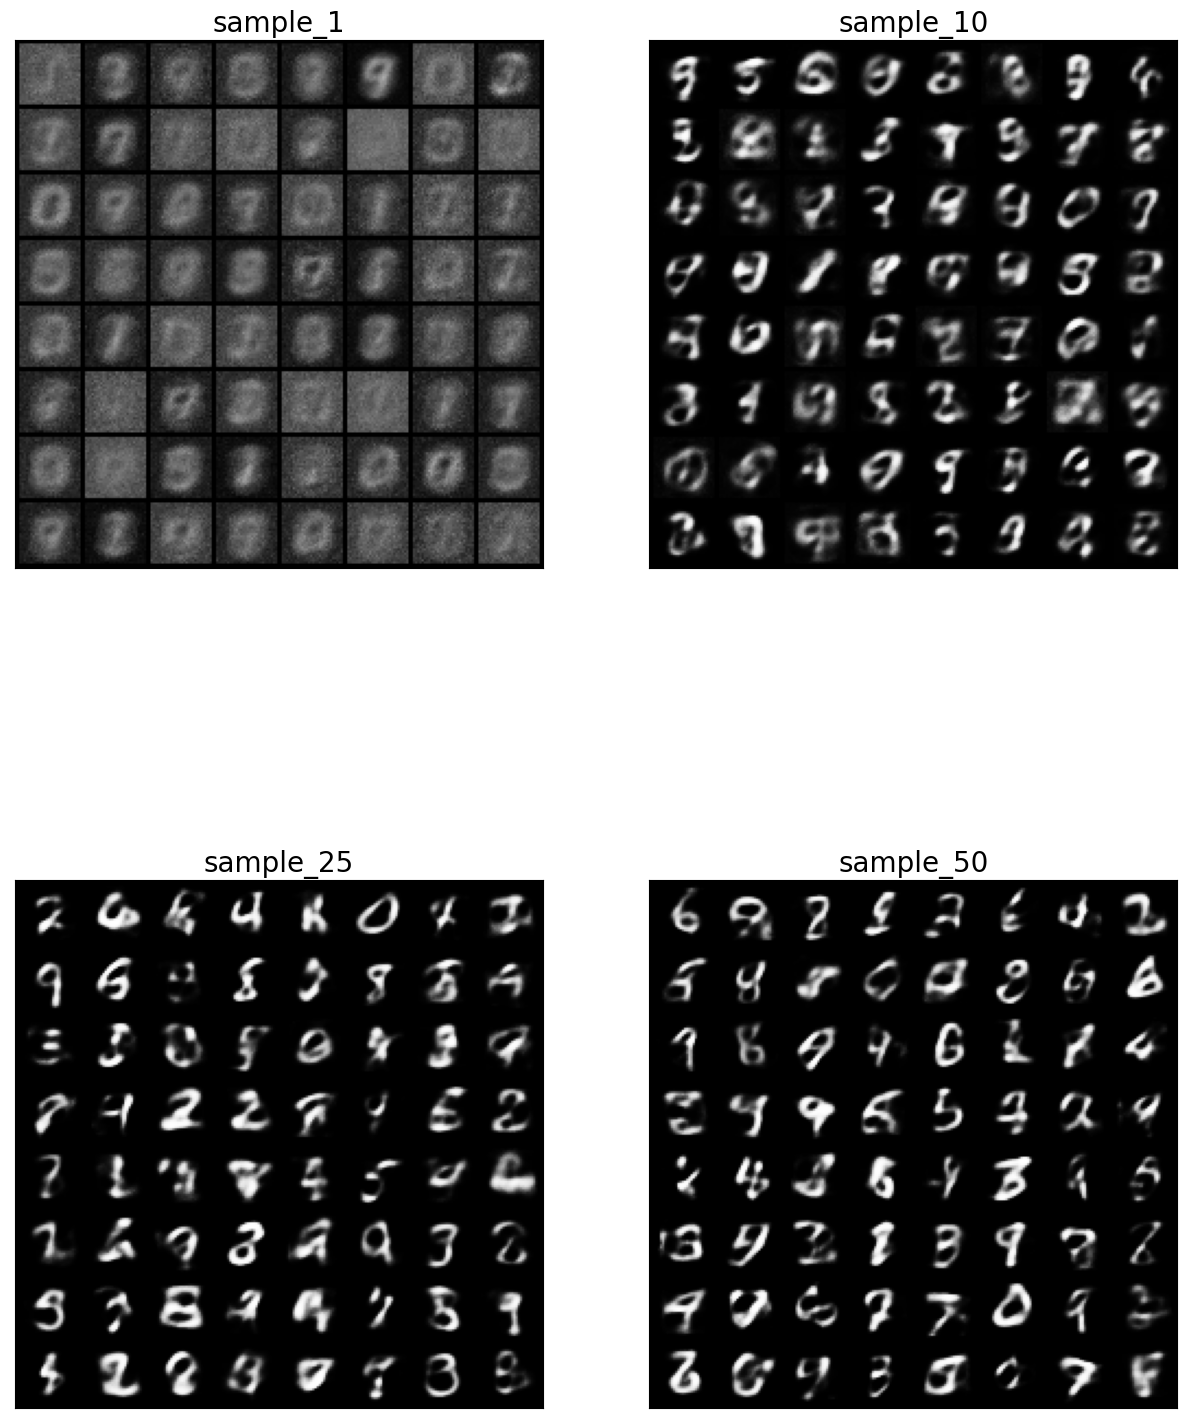

In [55]:
# Load some of the images
from PIL import Image

fig,ax = plt.subplots(2,2,figsize=(15,20))
ax = ax.ravel()
img0 = np.array(Image.open('./plots_VAE/sample_1.png'))
img10 = np.array(Image.open('./plots_VAE/sample_10.png'))
img25 = np.array(Image.open('./plots_VAE/sample_25.png'))
img50 = np.array(Image.open('./plots_VAE/sample_50.png'))
# img100 = np.array(Image.open('./plots_VAE/sample_40.png'))
# img250 = np.array(Image.open('./plots_VAE/gen_img250.png'))
# img500 = np.array(Image.open('./plots_VAE/gen_img500.png'))
# img750 = np.array(Image.open('./plots_VAE/gen_img750.png'))
# img800 = np.array(Image.open('./plots_VAE/gen_img800.png'))

ax[0].imshow(img0, cmap='gray'); #set colormap as 'gray'
ax[0].set_title("sample_1", fontsize=20);
ax[0].grid(False), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(img10, cmap='gray'); #set colormap as 'gray'
ax[1].set_title("sample_10", fontsize=20);
ax[1].grid(False), ax[1].set_xticks([]), ax[1].set_yticks([])
ax[2].imshow(img25, cmap='gray'); #set colormap as 'gray'
ax[2].set_title("sample_25", fontsize=20);
ax[2].grid(False), ax[2].set_xticks([]), ax[2].set_yticks([])
ax[3].imshow(img50, cmap='gray'); #set colormap as 'gray'
ax[3].set_title("sample_50", fontsize=20);
ax[3].grid(False), ax[3].set_xticks([]), ax[3].set_yticks([]);

targets[:20]: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
latentVar[:20]: [[ 0.4345273  -2.0758858 ]
 [-1.7275175   1.73347   ]
 [-2.3370457  -1.182199  ]
 [ 1.4374125   1.3277956 ]
 [ 1.5242178   0.15514581]
 [-2.391573   -1.6443951 ]
 [ 0.39003208 -0.8101333 ]
 [ 0.13342007 -0.6954995 ]
 [ 1.511218    0.1030663 ]
 [ 1.5362703  -1.3021046 ]
 [ 0.8909025   1.9830539 ]
 [ 0.04927514  1.0719461 ]
 [ 2.099978   -2.4311435 ]
 [ 1.7917511   1.1359222 ]
 [-2.1678288  -0.9019176 ]
 [-0.81085646  1.4696523 ]
 [ 1.8733207  -0.78752005]
 [ 0.7151663  -1.2338539 ]
 [-0.77720845  0.6400718 ]
 [ 1.0180765  -0.99701256]]
x0,y0: 0.43452730774879456,-2.075885772705078
x1,y1: -1.7275174856185913,1.7334699630737305
xvals: [ 0.43452731  0.19430011 -0.04592709 -0.28615429 -0.52638149 -0.76660869
 -1.00683589 -1.24706309 -1.48729029 -1.72751749]
yvals: [-2.07588577 -1.65262402 -1.22936228 -0.80610053 -0.38283878  0.04042297
  0.46368472  0.88694647  1.31020821  1.73346996]


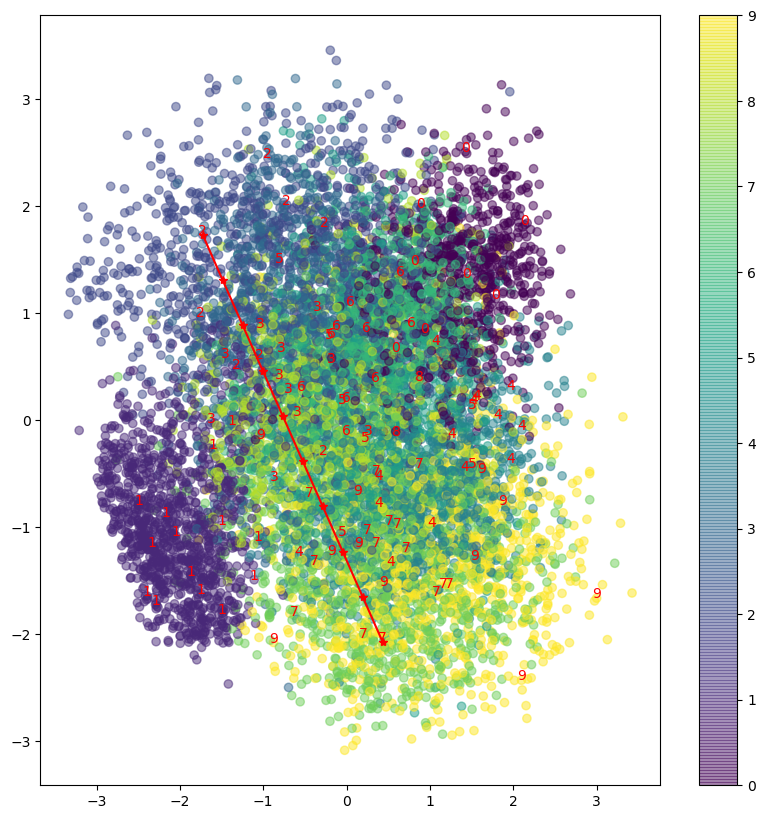

In [45]:
# Visualize the 2D space
# Should we use PCA to embeded the 20D to 2D? 
import matplotlib
from sklearn.decomposition import PCA
matplotlib.style.use('default')

large_batch = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=60000, 
                                          shuffle=False)

with torch.no_grad():
    model_VAE.eval()
    data, targets = next(iter(large_batch))
    targets = targets.numpy()
    data = data.to(device)
    recon_batch, mu, logvar = model_VAE(data)
    
    #Reduce dimensions to 2D
    pca = PCA(n_components=2)
    latentVar = pca.fit_transform(mu.cpu().numpy())
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:], alpha=0.5)
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(26))
    n_points=100
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[0,0],latentVar[0,1]
    x1,y1 = latentVar[1,0],latentVar[1,1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')

In [49]:
# ## Visualizing the embedding using different algorithms
# # reducer = phate.PHATE(n_components=2, random_state=1, knn=5, t=2)#, n_neighbors=8)
# reducer = umap.UMAP(n_components=2)
# # reducer = PCA(n_components=2,random_state=np.random.RandomState(42))

# with torch.no_grad():
#     model_VAE.eval()
#     data, targets = next(iter(large_batch))
#     targets = targets.numpy()
#     data = data.to(device)
#     recon_batch, mu, logvar = model_VAE(data)
    
#     #Reduce dimensions to 2D
#     latentVar = reducer.fit_transform(mu.cpu().numpy())
    
#     fig,ax = plt.subplots(1,1,figsize=(10,10))
#     plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:], alpha=0.5)
#     print('targets[:20]: {}'.format(targets[:20]))
#     print('latentVar[:20]: {}'.format(latentVar[:20]))

#     plt.colorbar(ticks=range(26))
#     n_points=100
#     for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

#         label = targets[i]

#         plt.annotate(label, # this is the text
#                      (x,y), # this is the point to label
#                      textcoords="offset points", # how to position the text
#                      c='r',
#                      xytext=(0,0), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be left, right or center

#     # Get the first two points of latentVar
#     x0,y0 = latentVar[0,0],latentVar[0,1]
#     x1,y1 = latentVar[1,0],latentVar[1,1]
#     xvals = np.array(np.linspace(x0, x1, 10))
#     yvals = np.array(np.linspace(y0, y1, 10))
#     print('x0,y0: {},{}'.format(x0,y0))
#     print('x1,y1: {},{}'.format(x1,y1))
#     print('xvals: {}'.format(xvals))
#     print('yvals: {}'.format(yvals))
#     plt.plot(xvals[:],yvals[:],c='r',marker='*')

In [46]:
print(logvar.max())
print(logvar.mean())
print(logvar.min())
print(logvar.shape)
print(mu.shape)

tensor(-0.4241, device='cuda:0')
tensor(-2.4555, device='cuda:0')
tensor(-4.5016, device='cuda:0')
torch.Size([10000, 20])
torch.Size([10000, 20])


In [47]:
class VAE_decoder(nn.Module):
    def __init__(self):
        super(VAE_decoder, self).__init__()
        
        self.fc1 = model_VAE.fc1
        self.fc21 = model_VAE.fc21
        self.fc22 = model_VAE.fc22
        self.fc3 = model_VAE.fc3
        self.fc4 = model_VAE.fc4

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, mu):
#         mu, logvar = self.encode(x.view(-1, 784))
        logvar=torch.ones_like(mu) * -2.5
        z = self.reparameterize(mu, logvar)
        print('z.shape: {}'.format(z.shape))
        return self.decode(z)


z.shape: torch.Size([20])
z.shape: torch.Size([20])
z.shape: torch.Size([20])
z.shape: torch.Size([20])
z.shape: torch.Size([20])
z.shape: torch.Size([20])
z.shape: torch.Size([20])
z.shape: torch.Size([20])
z.shape: torch.Size([20])
z.shape: torch.Size([20])


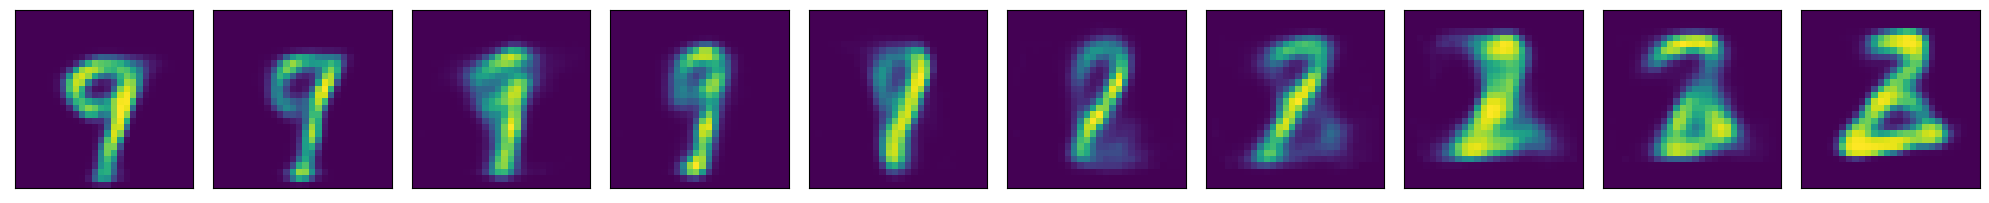

In [53]:
with torch.no_grad():

    model = VAE_decoder()

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = pca.inverse_transform(model_input) #Take it back to 20D
        model_input = torch.from_numpy(model_input).float()

#         print('model_input: {}'.format(model_input))

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

[2 5]
targets[:20]: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
latentVar[:20]: [[ 0.40736163 -2.016721  ]
 [-1.7871908   1.8029145 ]
 [-2.4138377  -1.0730588 ]
 [ 1.4500079   1.3393097 ]
 [ 1.5667887   0.18621157]
 [-2.4832506  -1.5611724 ]
 [ 0.3383248  -0.7750838 ]
 [ 0.15037093 -0.7030073 ]
 [ 1.6512418   0.00962092]
 [ 1.4932861  -1.287865  ]
 [ 0.8657939   2.0630798 ]
 [ 0.0030186   1.1436319 ]
 [ 2.04184    -2.4532917 ]
 [ 1.683633    1.1927067 ]
 [-2.0752797  -0.96671087]
 [-0.8658705   1.5018108 ]
 [ 1.9670589  -0.83187914]
 [ 0.6600126  -1.163702  ]
 [-0.8519091   0.5989827 ]
 [ 0.8936179  -0.9364094 ]]
x0,y0: -2.4138376712799072,-1.073058843612671
x1,y1: -2.483250617980957,-1.561172366142273
xvals: [-2.41383767 -2.42155022 -2.42926277 -2.43697532 -2.44468787 -2.45240042
 -2.46011297 -2.46782552 -2.47553807 -2.48325062]
yvals: [-1.07305884 -1.12729368 -1.18152852 -1.23576335 -1.28999819 -1.34423302
 -1.39846786 -1.45270269 -1.50693753 -1.56117237]
z.shape: torch.Size([20])
z.sh

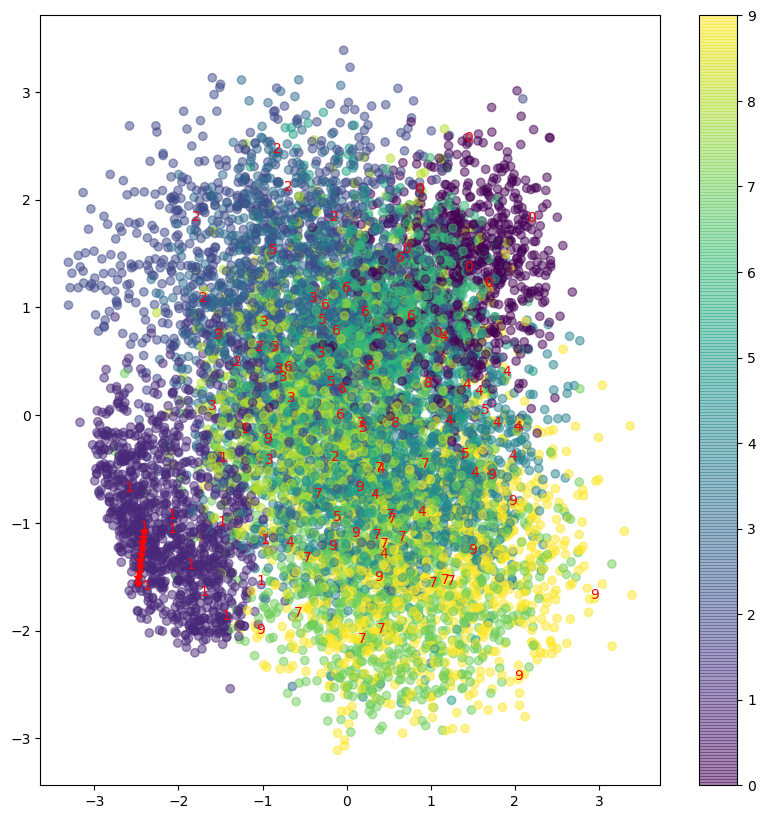

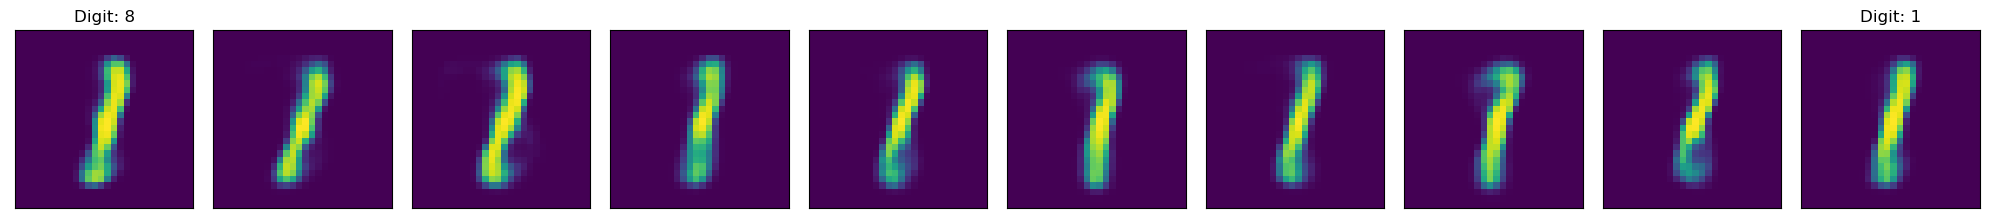

In [54]:
# Redo for digits in the same class
with torch.no_grad():
    model_VAE.eval()
    data, targets = next(iter(large_batch))
    targets = targets.numpy()
    idx_ = np.where(targets==1)[0] # Get two '6'.
    print(idx_[:2])
    data = data.to(device)
    recon_batch, mu, logvar = model_VAE(data)
    
    #Reduce dimensions to 2D
    pca = PCA(n_components=2)
    latentVar = pca.fit_transform(mu.cpu().numpy())
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:], alpha=0.5)
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(26))
    n_points=100
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):
        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[idx_[0],0],latentVar[idx_[0],1]
    x1,y1 = latentVar[idx_[1],0],latentVar[idx_[1],1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')

    model = VAE_decoder()

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = pca.inverse_transform(model_input) #Take it back to 20D
        model_input = torch.from_numpy(model_input).float()

#         print('model_input: {}'.format(model_input))

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1
        
ax[0].set_title('Digit: 8')
ax[9].set_title('Digit: 1')
fig.tight_layout()

## Question 3.1.1. 
__How does the VAE's latent space compare to the latent space of your previous autoencoder?
Do the generated images have more clarity? Is this most noticeable between or within classes?__

## Question 3.1.2. 
__In what situations would a VAE be more useful than a vanilla autoencoder, and when
would you prefer a vanilla autoencoder to a VAE?__


## Question 3.1.3. 
__The distance between embeddings in your first autoencoder provided some measure of the
similarity between digits. To what extent is this preserved, or improved, by the VAE?__

# Section 3.2 - GANS

Whereas the VAE was tweaked to allow small perturbations in the latent space to produce reasonable decodings, the Generative Adversarial Network was designed to generate novel samples. A GAN is really two networks in one: the generator network produces fake images, while the discriminator guesses if they are fake. Initially, both networks perform horribly, but with time (and luck) they force each other to improve until the generator's images are indistinguishable from the real thing. In this part, you'll build your own GAN in PyTorch, and test it on the MNIST dataset.

<img src="./images/GANs_architecture1.png" alt="drawing" width="800"/>
<img src="./images/GANS_architecture2.png" alt="drawing" width="800"/>
<img src="./images/GANs_Loss.png" alt="drawing" width="800"/>

In [56]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.autograd import Variable
matplotlib.style.use('default')

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # the dimension of the random noise used to seed the Generator
        self.main = nn.Sequential( # nn.sequential is a handy way of combining multiple layers.
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(), # Original: Tanh. Use a sigmoid
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


def train_discriminator(optimizer, real_data, fake_data):
    """
    Train the discriminator on a minibatch of data.
    INPUTS
        :param optimizer: the optimizer used for training
        :param real_data: the batch of training data
        :param fake_data: the data generated by the generator from random noise
    The discriminator will incur two losses: one from trying to classify the real data, and another from classifying the fake data.
    TODO: Fill in this function.
    It should
    1. Run the discriminator on the real_data and the fake_data
    2. Compute and sum the respective loss terms (described in the assignment)
    3. Backpropogate the loss (e.g. loss.backward()), and perform optimization (e.g. optimizer.step()).
    """
    
    optimizer.zero_grad()
        
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    y_real = Variable(torch.ones(prediction_real.shape[0], 1))
    D_real_loss = criterion(prediction_real, y_real.to(device))


    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    y_fake = Variable(torch.zeros(prediction_fake.shape[0], 1))
    D_fake_loss = criterion(prediction_fake, y_fake.to(device))
    
    D_loss = (D_real_loss + D_fake_loss)/2
    D_loss.backward()
    optimizer.step()
    
    # we'll return the loss for book-keeping purposes. (E.g. if you want to make plots of the loss.)
    return D_loss

def train_generator(optimizer, fake_data):
    """
    Performs a single training step on the generator.
    :param optimizer: the optimizer
    :param fake_data: forgeries, created by the generator from random noise. (Done before calling this function.)
    :return:  the generator's loss
    TODO: Fill in this function
    It should
    1. Run the discriminator on the fake_data
    2. compute the resultant loss for the generator (as described in the assignment)
    3. Backpropagate the loss, and perform optimization
    """
    
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    y = Variable(torch.ones(prediction.shape[0], 1))
    G_loss = criterion(prediction, y.to(device))
    G_loss.backward()
    optimizer.step()

    return G_loss/2



In [57]:
path_to_save = './plots_GANs'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
    
    
num_epochs = 1000
nz = 100# dimension of random noise
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss().to(device)

# Optimizers (notice the use of 'discriminator'<-Object class)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002) # 1: 3e-4; 2: 1e-5

In [45]:
#TODO: Build a training loop for the GAN
# For each epoch, you'll
# 1. Loop through the training data. For each batch, feed random noise into the generator to generate fake_data of the corresponding size.
# 2. Feed the fake data and real data into the train_discriminator and train_generator functions
# At the end of each epoch, use the below functions to save a grid of generated images.
for epoch in range(num_epochs):
    train_loss = 0
    train_d_error = 0
    train_g_error = 0
    for batch_idx, (data, _) in enumerate(train_loader):

        # 1. Train Discriminator
        real_data = Variable(data).to(device)
       
        # Generate fake data
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (data.shape[0], nz)))).to(device)
        
        fake_data = generator(z).detach() # Because we don't want the generator being trained while the discriminator is being trained        

        # Train D
        d_error = train_discriminator(d_optimizer, real_data, fake_data).item()#, discriminator, criterion)


        # 2. Train Generator
        # Generate fake data
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (data.shape[0], nz)))).to(device)
        generated_img = generator(z)

        # Train G
        g_error = train_generator(g_optimizer, generated_img).item()
        
        train_loss += d_error + g_error
        train_d_error += d_error
        train_g_error += g_error
        
    print('====> Epoch: {} Average loss: {:.6f} (D_error: {:.6f}, G_error: {:.6f})'.format(
      epoch, train_loss / len(train_loader.dataset), train_d_error/ len(train_loader.dataset),
            train_g_error / len(train_loader.dataset)))
    
#     if epoch == 100:
#         torch.save(generator.state_dict(), './models/generator_100epochs.pt')
#         torch.save(discriminator.state_dict(), './models/discriminator_100epochs.pt')

    # reshape the image tensors into a grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor images
    save_image(generated_img, f"./plots_GANs/gen_img{epoch}.png")

====> Epoch: 0 Average loss: 0.009112 (D_error: 0.005233, G_error: 0.003878)
====> Epoch: 1 Average loss: 0.011252 (D_error: 0.004452, G_error: 0.006800)
====> Epoch: 2 Average loss: 0.016729 (D_error: 0.004336, G_error: 0.012393)
====> Epoch: 3 Average loss: 0.013045 (D_error: 0.003964, G_error: 0.009081)
====> Epoch: 4 Average loss: 0.012556 (D_error: 0.003082, G_error: 0.009474)
====> Epoch: 5 Average loss: 0.012022 (D_error: 0.002859, G_error: 0.009164)
====> Epoch: 6 Average loss: 0.011667 (D_error: 0.002569, G_error: 0.009097)
====> Epoch: 7 Average loss: 0.012540 (D_error: 0.003023, G_error: 0.009517)
====> Epoch: 8 Average loss: 0.011756 (D_error: 0.002783, G_error: 0.008973)
====> Epoch: 9 Average loss: 0.011427 (D_error: 0.002824, G_error: 0.008603)
====> Epoch: 10 Average loss: 0.011226 (D_error: 0.002858, G_error: 0.008368)
====> Epoch: 11 Average loss: 0.011279 (D_error: 0.002739, G_error: 0.008540)
====> Epoch: 12 Average loss: 0.011694 (D_error: 0.002860, G_error: 0.0088

In [46]:
# torch.save(generator.state_dict(), './models/generator.pt')
# torch.save(discriminator.state_dict(), './models/discriminator.pt')

In [58]:
# Loading
num_epochs = 1000
nz = 100# dimension of random noise
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss().to(device)
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
generator.load_state_dict(torch.load('./models/generator_100epochs.pt'))
discriminator.load_state_dict(torch.load('./models/discriminator_100epochs.pt'))

<All keys matched successfully>

Text(0.5, 0.98, 'After 1000 epochs')

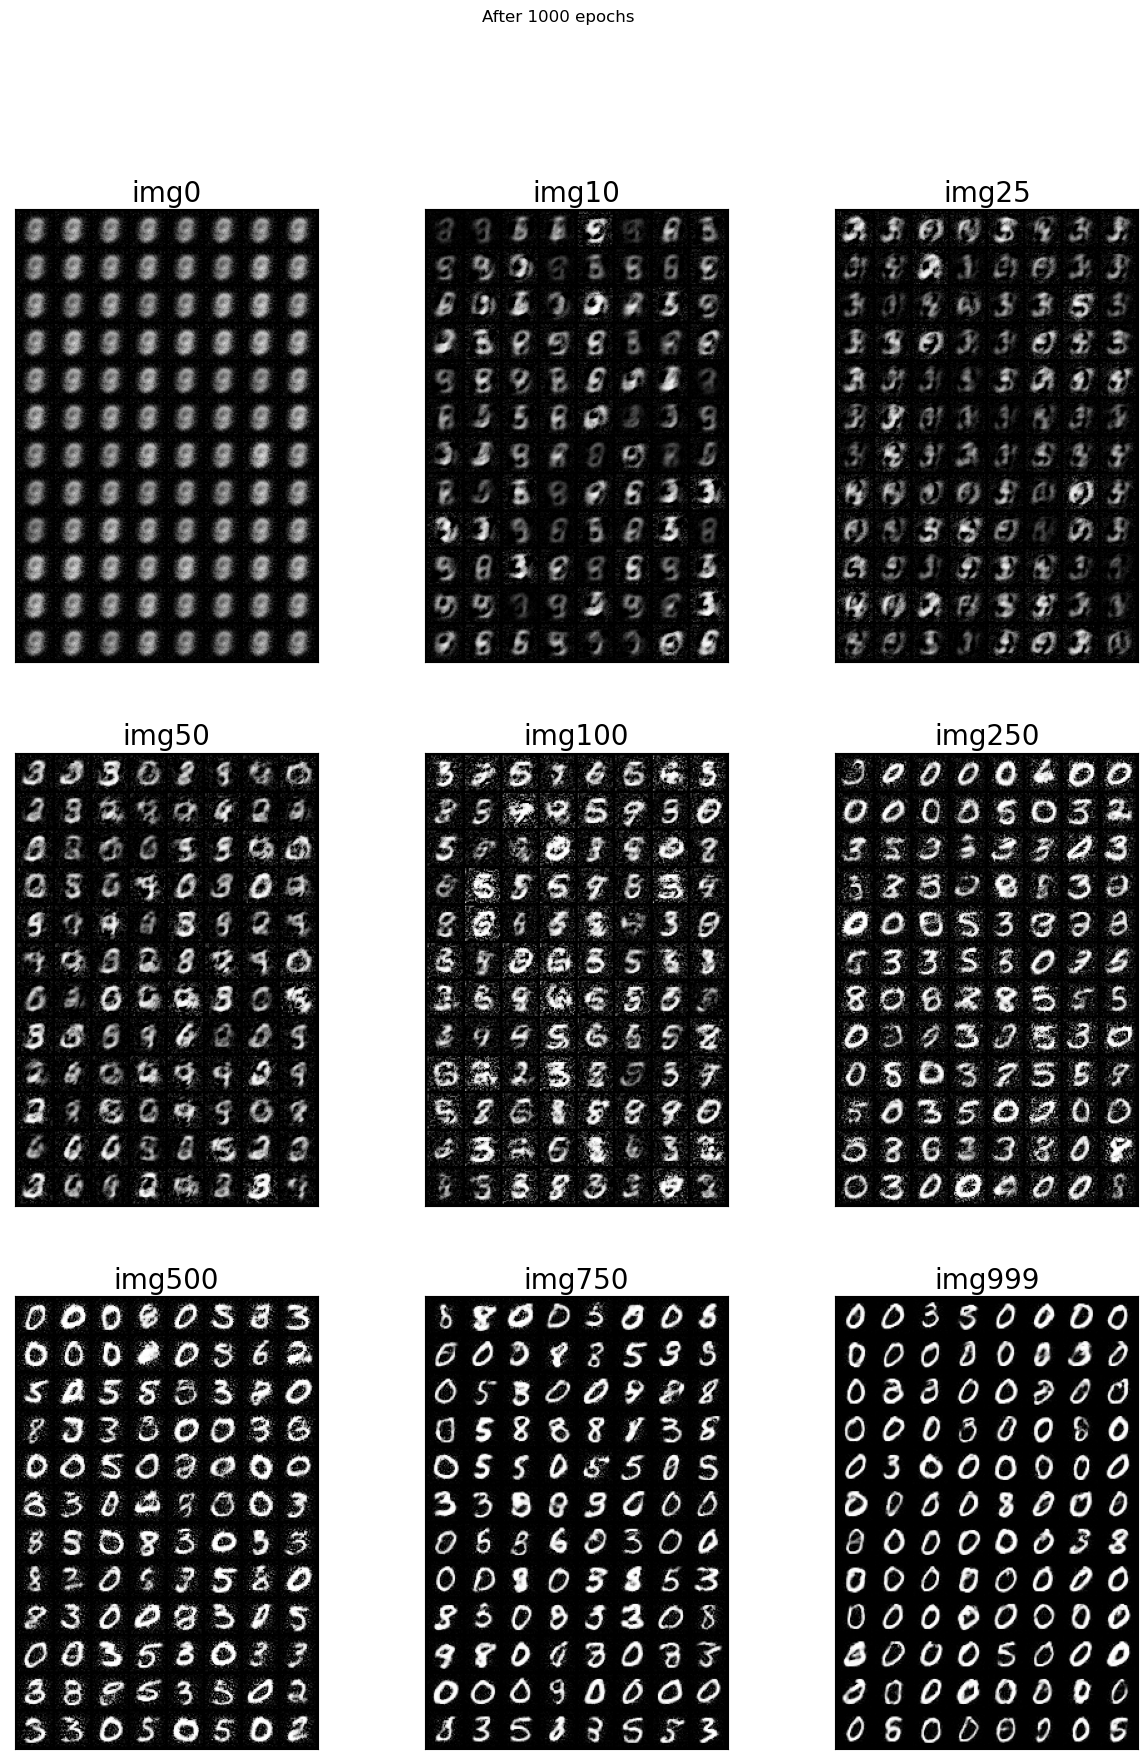

In [59]:
# Load some of the images
from PIL import Image
plt.close('all')
fig,ax = plt.subplots(3,3,figsize=(15,20))
ax = ax.ravel()
img0 = np.array(Image.open('./plots_GANs/gen_img0.png'))
img10 = np.array(Image.open('./plots_GANs/gen_img10.png'))
img25 = np.array(Image.open('./plots_GANs/gen_img25.png'))
img50 = np.array(Image.open('./plots_GANs/gen_img50.png'))
img100 = np.array(Image.open('./plots_GANs/gen_img100.png'))
img250 = np.array(Image.open('./plots_GANs/gen_img250.png'))
img500 = np.array(Image.open('./plots_GANs/gen_img500.png'))
img750 = np.array(Image.open('./plots_GANs/gen_img750.png'))
img999 = np.array(Image.open('./plots_GANs/gen_img999.png'))

ax[0].imshow(img0, cmap='gray'); #set colormap as 'gray'
ax[0].set_title("img0", fontsize=20)
ax[1].grid(False), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(img10, cmap='gray'); #set colormap as 'gray'
ax[1].set_title("img10", fontsize=20);
ax[1].grid(False), ax[1].set_xticks([]), ax[1].set_yticks([])
ax[2].imshow(img25, cmap='gray'); #set colormap as 'gray'
ax[2].set_title("img25", fontsize=20)
ax[2].grid(False), ax[2].set_xticks([]), ax[2].set_yticks([])
ax[3].imshow(img50, cmap='gray'); #set colormap as 'gray'
ax[3].set_title("img50", fontsize=20)
ax[3].grid(False), ax[3].set_xticks([]), ax[3].set_yticks([])
ax[4].imshow(img100, cmap='gray'); #set colormap as 'gray'
ax[4].set_title("img100", fontsize=20)
ax[4].grid(False), ax[4].set_xticks([]), ax[4].set_yticks([])
ax[5].imshow(img250, cmap='gray'); #set colormap as 'gray'
ax[5].set_title("img250", fontsize=20)
ax[5].grid(False), ax[5].set_xticks([]), ax[5].set_yticks([])
ax[6].imshow(img500, cmap='gray'); #set colormap as 'gray'
ax[6].set_title("img500", fontsize=20)
ax[6].grid(False), ax[6].set_xticks([]), ax[6].set_yticks([])
ax[7].imshow(img750, cmap='gray'); #set colormap as 'gray'
ax[7].set_title("img750", fontsize=20)
ax[7].grid(False), ax[7].set_xticks([]), ax[7].set_yticks([])
ax[8].imshow(img999, cmap='gray'); #set colormap as 'gray'
ax[8].set_title("img999", fontsize=20)
ax[8].grid(False), ax[8].set_xticks([]), ax[8].set_yticks([])
fig.suptitle('After 1000 epochs')


lr: 0.001, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
n. of epochs: 50
 EPOCH 0. Progress: 0.0%. 
 Training accuracy: 89.4250. Test accuracy: 89.6800. Loss Train: 0.9223. Loss Val: 0.3674. Time: 48.3126
 EPOCH 10. Progress: 20.0%. 
 Training accuracy: 97.1283. Test accuracy: 96.1700. Loss Train: 0.1009. Loss Val: 0.1184. Time: 49.2043
 EPOCH 20. Progress: 40.0%. 
 Training accuracy: 98.2583. Test accuracy: 96.9700. Loss Train: 0.0596. Loss Val: 0.1015. Time: 48.0787
 EPOCH 30. Progress: 60.0%. 
 Training accuracy: 98.6050. Test accuracy: 97.3800. Loss Train: 0.0

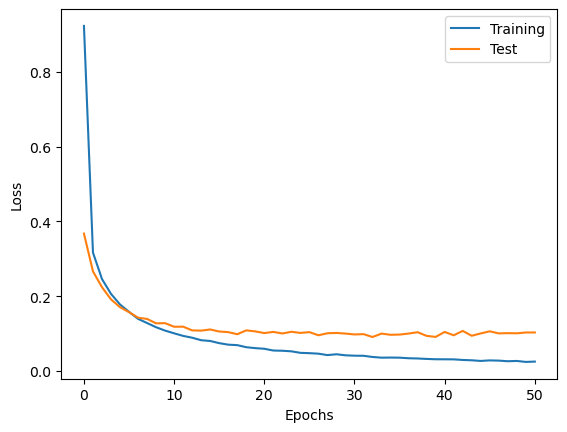

In [80]:
## Train a FFnet on the MNIST
# ./plots/lr0.001_3FFNet_2ReLU_Drop_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim128.png
# Testing a regular FFnet
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.drop = nn.Dropout(0.2)
        # Non-linearity
        self.sigmoid = nn.Sigmoid()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function
        out = self.sigmoid(self.fc1(x))
        out = self.drop(out)
        out = self.sigmoid(self.fc2(out))
        out = self.drop(out)
        out = self.fc3(out)
        return out
    
# Training and Evaluation routines
def train_FF(model,loss_fn, optimizer, train_loader, test_loader, num_epochs=None, verbose=False):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    print('optimizer: {}'.format(optimizer))
    if num_epochs is None:
        num_epochs = 100 # obviously, this is too many. I don't know what this author was thinking.
    print('n. of epochs: {}'.format(num_epochs))
    train_loss=[]
    val_loss=[]
    for epoch in range(num_epochs+1):
        # loop through each data point in the training set
        all_loss_train=0
        for data, targets in train_loader:
            start = time.time()
            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
                
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            out = model(model_input)

            # Calculate the loss
            targets = targets.to(device) # add an extra dimension to keep CrossEntropy happy.
            loss = loss_fn(out,targets)
            
            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            all_loss_train += loss.item()
        train_loss.append(all_loss_train/len(train_loader))
            
        with torch.no_grad():
            all_loss_val=0
            for data, targets in test_loader:

                # run the model on the data
                model_input = data.view(data.size(0),-1).to(device)
                out = model(model_input)
                targets = targets.to(device) # add an extra dimension to keep CrossEntropy happy.
                loss = loss_fn(out,targets)
                all_loss_val += loss.item()
            val_loss.append(all_loss_val/len(test_loader))
                    
        
        # Give status reports every 100 epochs
        if epoch % 10==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            print(" Training accuracy: {:.4f}. Test accuracy: {:.4f}. Loss Train: {:.4f}. Loss Val: {:.4f}. Time: {:.4f}".format(evaluate_FF(model,train_loader,verbose), 
                                                                                                         evaluate_FF(model,test_loader,verbose), 
                                                                                                         train_loss[-1], val_loss[-1], 10*(time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.
    # Plot 
    plt.close('all')
    fig,ax = plt.subplots()
    ax.plot(np.arange(num_epochs+1),train_loss, label='Training')
    ax.plot(np.arange(num_epochs+1),val_loss, label='Test')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

def evaluate_FF(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
#             if verbose:
#                 print('model_input.shape: {}'.format(model_input.shape))
#                 print('targets.shape: {}'.format(targets.shape))
            out = model(model_input)
            if verbose: print('out[:5]: {}'.format(out[:5]))
            _, predicted = torch.max(out, 1)
            if verbose:
                print('predicted[:5]: {}'.format(predicted[:5]))
                print('targets[:5]: {}'.format(targets[:5]))
            total+= targets.size(0)
            correct+= (predicted == targets.to(device)).sum()
            if verbose:
                print('total: {}'.format(total))
                print('correct: {}'.format(correct))
                print('100*float(correct/total): {}'.format(100*float(correct)/float(total)))
        accuracy = 100 * float(correct)/float(total)
    return accuracy


# Best configuration for longer
lr = 0.001
hid_dim = 128
weight_decay = 0.001
momentum = 0.9
dampening = 0
nesterov = False
print('\nlr: {}, momentum: {}, weight_decay: {}, dampening: {}, nesterov: {} '.format(lr, momentum, weight_decay, dampening, nesterov))
model = FeedforwardNeuralNetModel(input_dim=28*28,hidden_dim=hid_dim, output_dim=10).to(device)
print(model)
ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
loss_fn = nn.CrossEntropyLoss().to(device)
config_str = 'lr' + str(lr) + '_3FFNet_2ReLU_Drop_momentum' + str(momentum) + '_wdecay' + str(weight_decay) + '_dampening' + str(dampening) +'_nesterov' + str(nesterov) + '_HidDim' + str(hid_dim)
train_FF(model,loss_fn, ADAM, train_loader, test_loader,num_epochs=50, verbose=False)

torch.save(model.state_dict(), './models/FFnet.pt')

In [81]:
# Loading the GAN trained until 100 epochs

## Redo for the best result architecture (likely sigmoid)
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.drop = nn.Dropout(0.2)
        # Non-linearity
        self.sigmoid = nn.Sigmoid()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function
        out = self.sigmoid(self.fc1(x))
        out = self.drop(out)
        out = self.sigmoid(self.fc2(out))
        out = self.drop(out)
        out = self.fc3(out)
        return out
    
hid_dim = 128
num_epochs = 1000
nz = 100# dimension of random noise
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss().to(device)
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
generator.load_state_dict(torch.load('./models/generator_100epochs.pt'))
discriminator.load_state_dict(torch.load('./models/discriminator_100epochs.pt'))
model_FF = FeedforwardNeuralNetModel(input_dim=28*28,hidden_dim=hid_dim, output_dim=10).to(device)
model_FF.load_state_dict(torch.load('./models/FFnet.pt'))

<All keys matched successfully>

torch.Size([1000, 1, 28, 28])
i: 0, count: 0
out: tensor([[1.6919e-06, 3.5037e-04, 4.1101e-01, 3.4078e-04, 1.7192e-04, 1.7497e-03,
         3.7282e-01, 3.0823e-06, 2.1355e-01, 4.8999e-09]], device='cuda:0')
i: 10, count: 1
out: tensor([[7.4195e-06, 9.9243e-06, 9.9988e-01, 4.1398e-05, 6.8156e-10, 5.2755e-05,
         1.1153e-05, 4.7775e-08, 1.3324e-06, 1.3220e-08]], device='cuda:0')
i: 20, count: 2
out: tensor([[9.9819e-01, 1.3623e-08, 5.9072e-07, 6.9939e-09, 4.1629e-07, 7.4058e-04,
         1.0715e-03, 2.1307e-10, 1.3002e-07, 1.7062e-06]], device='cuda:0')
i: 30, count: 3
out: tensor([[2.1724e-07, 2.5237e-09, 5.6318e-13, 3.0929e-09, 1.6687e-08, 9.9999e-01,
         1.3929e-05, 1.9483e-12, 2.2087e-07, 1.1069e-08]], device='cuda:0')
i: 40, count: 4
out: tensor([[1.2610e-02, 9.5297e-07, 1.1935e-03, 8.1078e-05, 2.3644e-06, 4.6851e-02,
         1.0595e-02, 1.0947e-06, 9.2854e-01, 1.2085e-04]], device='cuda:0')
i: 50, count: 5
out: tensor([[3.2175e-06, 2.9241e-04, 5.8477e-03, 1.6690e-04, 1.6

/home/antonio2/miniconda3/envs/2pmeso_BERT/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


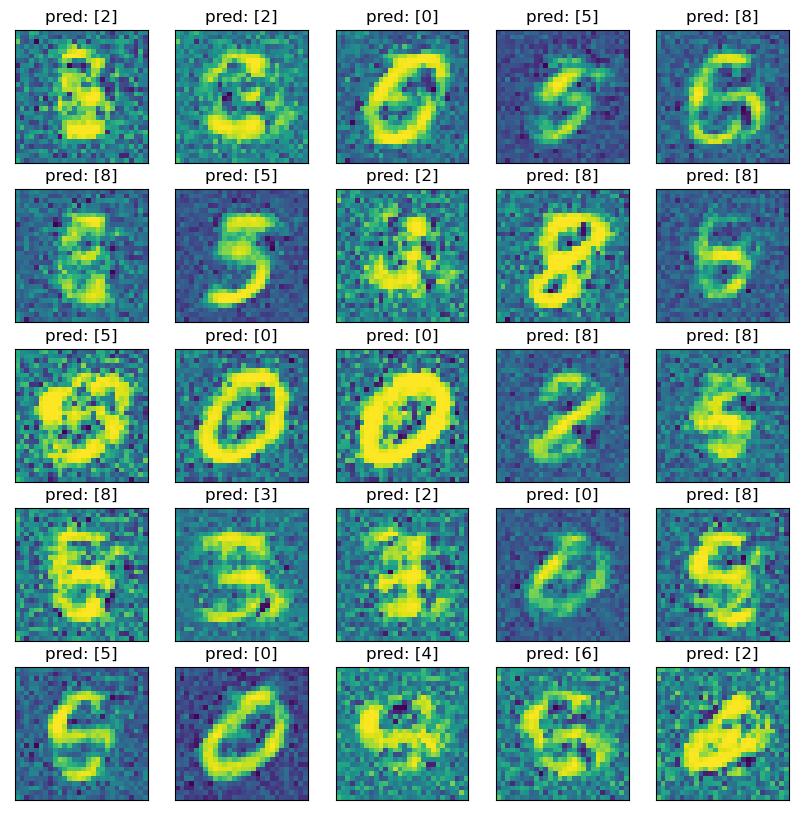

In [83]:
# Generate 1000 samples: and classify some
path_to_save = './samples_GAN'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

from torch.autograd import Variable
fig,ax = plt.subplots(5,5,figsize=(10,10))
ax = ax.ravel()
with torch.no_grad():
    generator.eval()
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (1000, nz)))).to(device)
    generated_img = generator(z)
    print(generated_img.shape)
    # save the generated torch tensor images
    count=0
    for i in range(generated_img.shape[0]):
        if i %10 == 0 and count < 25:
            save_image(generated_img[i,0,:,:], f"./samples_GAN/sample{i}.png")
            print('i: {}, count: {}'.format(i, count))
            data = generated_img[i,0,:,:].flatten()
            model_input = data.view(-1,data.size(0)).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            out = model_FF(model_input)
            out = F.softmax(out)
            print('out: {}'.format(out))
            _, predicted = torch.max(out, 1)
            ax[count].imshow(generated_img[i,0,:,:].cpu())
            ax[count].grid(False), ax[count].set_xticks([]), ax[count].set_yticks([])
            ax[count].set_title('pred: {}'.format(predicted.cpu().numpy()))
            count += 1
        

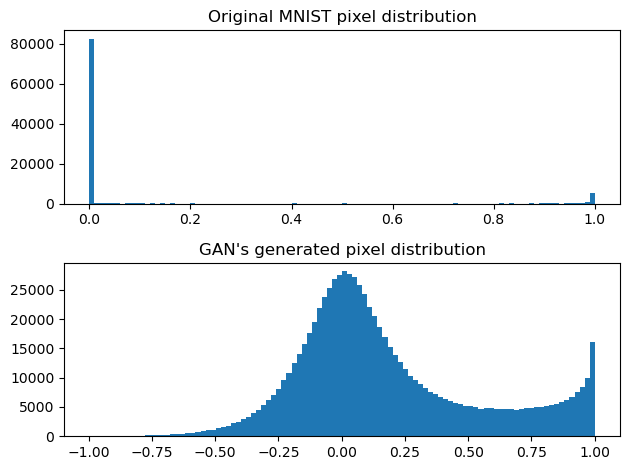

In [85]:
# checking the pixel distributions
fig,ax = plt.subplots(2,1)
# ax=ax.ravel()
data, targets = next(iter(test_loader))
ax[0].hist(data.flatten(),bins=100)
ax[0].set_title("Original MNIST pixel distribution")
ax[1].hist(generated_img[:,0,:,:].cpu().numpy().flatten(),bins=100)
ax[1].set_title("GAN's generated pixel distribution")
plt.tight_layout()

## Question 4.2.1. 
__Which generates more realistic images: your GAN, or your VAE? Why do you think this is?__

## Question 4.2.2. 
__Does your GAN appear to generate all digits in equal number, or has it specialized in a smaller number of digits? If so, why might this be?__
